# DOMAIN: Social Media Analytics

## CONTEXT:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to
other tweets and detecting sarcasm in these require the availability of contextual tweets. In this hands-on project,
the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

## DATASET DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the
following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal
usage. This reduces the sparsity and increases the chance of finding pre-trained embeddings. Furthermore, since
the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as
compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us inteasing apart the real sarcastic.

## Content:
Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection


## PROJECT OBJECTIVE:
Build a sequential NLP classifier which can use input text parameters to determine the customer sentiment.

In [2]:
#import necessory libreries
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow
print(tensorflow.__version__)


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

2.15.0


In [3]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read and explore the data

In [4]:
df=pd.read_json('/content/drive/My Drive/content/Sarcasm_Headlines_Dataset.json', lines = True)

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# . Define parameters

In [6]:
#information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
#Exploring the target class
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [8]:
df_sar=df.copy()

# Retain relevant columns

In [9]:
df_sar=df_sar.drop('article_link', axis=1)

In [10]:
df_sar.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Get length for each sentence

In [11]:
df_sar['headline_len'] = df_sar['headline'].apply(len)
df_sar.head()

,headline,is_sarcastic,headline_len
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


<ipython-input-12-a4589e3ba993>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sar['headline_len'])


<Axes: xlabel='headline_len', ylabel='Density'>

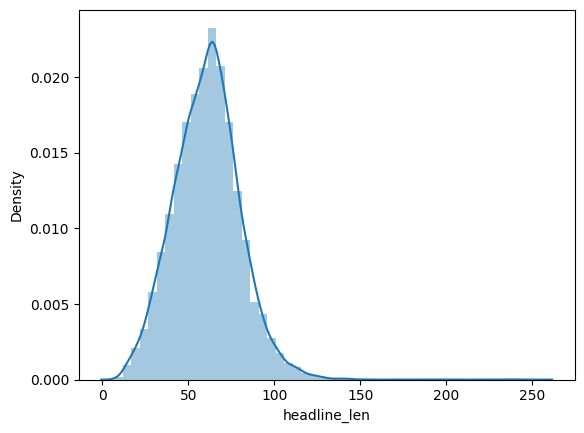

In [12]:
sns.distplot(df_sar['headline_len'])

## data is balanced

<Axes: xlabel='headline_len'>

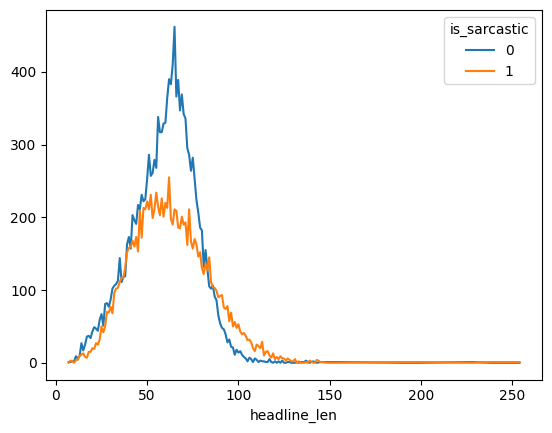

In [13]:
pd.crosstab(df_sar['headline_len'],df_sar['is_sarcastic']).plot()

In [14]:
df_sar.describe()

,is_sarcastic,headline_len
count,26709.000000,26709.000000
mean,0.438953,60.910592
std,0.496269,19.184470
min,0.000000,7.000000
25%,0.000000,48.000000
50%,0.000000,61.000000
75%,1.000000,73.000000
max,1.000000,254.000000


#

*   Get indices for words
*   Create features









In [15]:
def remove_special_characters(dataframe,columnname):
    dataframe_no_special_characters = dataframe[columnname].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    return dataframe_no_special_characters

df_sar['headline'] = remove_special_characters(df_sar,'headline')

In [16]:
# Convert to lower case
df_sar['text'] = df_sar['headline'].apply(lambda x: x.lower())

In [17]:
# removing the stop words
from nltk.corpus import stopwords
# Removing stop words
import string
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# Remove punctuations
df_sar['text'] = df_sar['text'].str.replace('[^\w\s]','')

<ipython-input-18-0c594708d22e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_sar['text'] = df_sar['text'].str.replace('[^\w\s]','')


In [19]:
df_sar.head(10)

,headline,is_sarcastic,headline_len,text
0,former versace store clerk sues over secret bl...,0,78,former versace store clerk sues over secret bl...
1,the roseanne revival catches up to our thorny ...,0,84,the roseanne revival catches up to our thorny ...
2,mom starting to fear sons web series closest t...,1,79,mom starting to fear sons web series closest t...
3,boehner just wants wife to listen not come up ...,1,84,boehner just wants wife to listen not come up ...
4,jk rowling wishes snape happy birthday in the ...,0,64,jk rowling wishes snape happy birthday in the ...
5,advancing the worlds women,0,27,advancing the worlds women
6,the fascinating case for eating labgrown meat,0,46,the fascinating case for eating labgrown meat
7,this ceo will send your kids to school if you ...,0,67,this ceo will send your kids to school if you ...
8,top snake handler leaves sinking huckabee camp...,1,50,top snake handler leaves sinking huckabee camp...
9,fridays morning email inside trumps presser fo...,0,59,fridays morning email inside trumps presser fo...


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_features=10000

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(df_sar['text']))

In [21]:
# Add padding
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)

    if train == True:
        max_seq_length = np.max(list(map(len, sequences)))

    sequences = tensorflow.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences

*   Get vocabulary size

In [22]:
vocabulory_size = len(tokenizer.word_index) + 1
print('Vocabulary size/Numer of unique tokens:', vocabulory_size)

Vocabulary size/Numer of unique tokens: 28398


# Create a weight matrix using GloVe embeddings

In [24]:
#downloding GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-02-18 09:21:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-18 09:21:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-18 09:21:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
#Extract
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()


In [35]:
glove_embeddings = {}

for item in open('glove.6B.200d.txt',errors="ignore"):
    word = item.split(' ')[0]
    embed = item.split(' ')[1:]
    embed = np.asarray(embed, dtype = 'float32')
    glove_embeddings[word] = embed

In [36]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

28398


In [37]:
#minimum_number_words = min(max_features, vocabulory_size) + 1

embedding_size = 200

embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
print (len(glove_embeddings))

400000


In [40]:
print(embedding_matrix.shape)

(28398, 200)


In [41]:
#spliting the data
def preprocess_inputs(df):

    # Split df into X and y
    y = df_sar['is_sarcastic']
    X = df_sar['text']



    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True, random_state=1)

    # Create and fit tokenizer
    tokenizer = tensorflow.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train)
    vocab_size= len(tokenizer.word_index) + 1

    print("Vocab length:", vocab_size)

    # Get sequence data
    X_train = get_sequences(texts=X_train, tokenizer=tokenizer, train=True)
    X_test = get_sequences(texts=X_test, tokenizer=tokenizer, train=False, max_seq_length=X_train.shape[1])

    print("Sequence length:", X_train.shape[1])

    return X_train, X_test, y_train, y_test

In [42]:
X_train, X_test, y_train, y_test = preprocess_inputs(df_sar)

Vocab length: 12279
Sequence length: 39


In [43]:
X_train

array([[   37,   101,   661, ...,     0,     0,     0],
       [  838,  2394,   215, ...,     0,     0,     0],
       [ 1106,   838,   134, ...,     0,     0,     0],
       ...,
       [ 5250,  2868, 12275, ...,     0,     0,     0],
       [12277,   518,   964, ...,     0,     0,     0],
       [   24,     1,  5269, ...,     0,     0,     0]], dtype=int32)

In [44]:
y_train.shape

(5341,)

In [45]:
max_number_of_words = df_sar['headline_len'].max()
print(max_number_of_words)

254


# Define and compile a Bidirectional LSTM model

In [64]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.initializers import Constant

model = Sequential()
#model.add(Embedding(weights=[embedding_matrix],input_dim = 12279, output_dim = 64, input_length = 39))
model.add(Embedding(num_words,embedding_size, weights=[embedding_matrix],input_length = 39))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (32,)))
model.add(Dense(1, activation = 'sigmoid'))

In [65]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 39, 200)           5679600   
                                                                 
 bidirectional_2 (Bidirecti  (None, 39, 256)           336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)              

In [67]:
training_history=model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=100)

Epoch 1/10
43/43 [==============================] - 30s 526ms/step - loss: 0.6996 - accuracy: 0.5222 - val_loss: 0.6837 - val_accuracy: 0.5500
Epoch 2/10
43/43 [==============================] - 18s 418ms/step - loss: 0.6890 - accuracy: 0.5466 - val_loss: 0.6862 - val_accuracy: 0.5500
Epoch 3/10
43/43 [==============================] - 24s 575ms/step - loss: 0.6817 - accuracy: 0.5463 - val_loss: 0.6628 - val_accuracy: 0.5500
Epoch 4/10
43/43 [==============================] - 20s 477ms/step - loss: 0.6304 - accuracy: 0.6074 - val_loss: 0.5373 - val_accuracy: 0.7493
Epoch 5/10
43/43 [==============================] - 18s 425ms/step - loss: 0.5086 - accuracy: 0.7509 - val_loss: 0.5050 - val_accuracy: 0.7736
Epoch 6/10
43/43 [==============================] - 25s 579ms/step - loss: 0.3638 - accuracy: 0.8635 - val_loss: 0.4883 - val_accuracy: 0.7914
Epoch 7/10
43/43 [==============================] - 21s 485ms/step - loss: 0.2266 - accuracy: 0.9293 - val_loss: 0.5020 - val_accuracy: 0.7942

trainning accuracy 99% and validation accuracy 80% but loss is vary high.

---



In [68]:
pred = model.predict(X_test[0].reshape((1, 39)))

1/1 [==============================] - 1s 1s/step


In [69]:
print(pred[0]) # Sigmoid value

[0.9999866]


In [70]:
if pred[0] >= 0.5:
  print('Sarcastic')
else:
  print('Not Sarcastic')

Sarcastic


In [71]:
score = model.evaluate(X_test, y_test)
print("Loss: {}, Accuracy:{}".format(score[0], score[1]))

668/668 [==============================] - 40s 59ms/step - loss: 1.1508 - accuracy: 0.7923
Loss: 1.1508311033248901, Accuracy:0.7923062443733215


Text(0.5, 1.0, 'Training and validation loss')

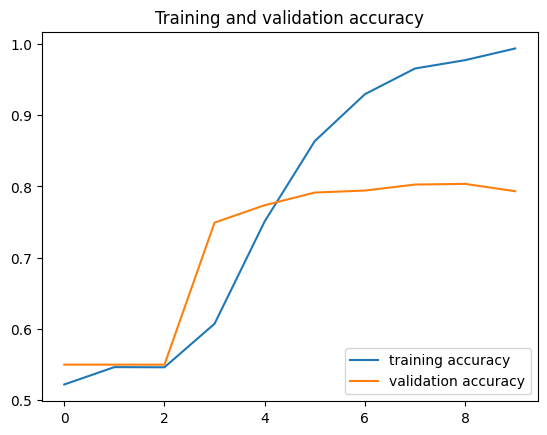

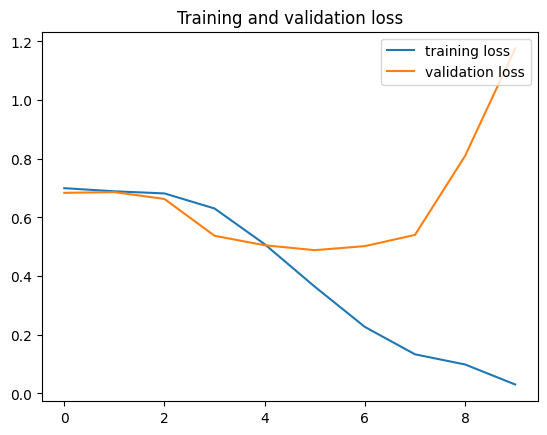

In [72]:
import matplotlib.pyplot as plt
accuracy      = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']
loss     = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )

# Summary



*   In this notebook, we have tried to build a sentiment classification model using embeddings and LSTM for news headline sarcasm detection.
*   we have used GloVe embedding for weight metrix.


*   To train the model we have used Bidirectional LSTM model
*   we have achieved almost 80% accuracy while testing the model but loss is very high



